# Load libraries

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# image processing
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import img_to_array

# pretrained nets
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [3]:
train_image_files_path = "/keras2production/fruits/Training/"
valid_image_files_path = "/keras2production/fruits/Test/"

# Keras

https://keras.io/

In [4]:
fruit_list = ["Apricot", "Avocado", "Banana", "Clementine", "Cocos", "Kiwi", "Lemon", "Limes", 
              "Mandarine", "Orange", "Peach", "Pineapple", "Plum", "Pomegranate", "Raspberry", "Strawberry"]
output_n = len(fruit_list)
size = 20
img_width = 20
img_height = 20
channels = 3
batch_size = 32

## Pretrained nets

https://keras.io/applications/

### Modify ResNet50

- transfer learning (freeze all but the penultimate layer and re-train the last Dense layer) and 
- fine tuning (un-freeze the lower convolutional layers and retrain more layers)

Validation set: fit_generator has no option validation_split

https://keras.io/applications/#usage-examples-for-image-classification-models

In [5]:
# important: exclude top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(197, 197, 3))
base_model.summary()

/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 203, 203, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

- Freeze the layers except the last x layers (try out what happens if you freeze different numbers of layers)

- combine the base model and train additional layers (try out what happens if you add different layers)

In [6]:
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-2]: 
    layer.trainable = False # weights will not be updated

In [7]:
train_data_gen = ImageDataGenerator(
    rescale = 1 / 255 # data can be normalised
)
## once for training data ans once for generator
valid_data_gen = ImageDataGenerator(
    rescale = 1 / 255
)

train_image_array_gen = train_data_gen.flow_from_directory( ## the images will only be loaded when needed
    train_image_files_path, ## path to the training images
    target_size = (197,197), 
    class_mode = 'categorical', ## because fruits are categories
    classes = fruit_list,
    color_mode = 'rgb', ## colormode defined
    batch_size = batch_size, 
    seed = 42) ## seed for generating numbers

valid_image_array_gen = valid_data_gen.flow_from_directory(
    valid_image_files_path,
    target_size = (197,197),
    class_mode = 'categorical',
    classes = fruit_list,
    color_mode = 'rgb', 
    batch_size = batch_size,
    seed = 42)

Found 7709 images belonging to 16 classes.
Found 2428 images belonging to 16 classes.


Shape:(197, 197, 3)
Number of classes:16
Classes:{'Apricot': 0, 'Avocado': 1, 'Banana': 2, 'Clementine': 3, 'Cocos': 4, 'Kiwi': 5, 'Lemon': 6, 'Limes': 7, 'Mandarine': 8, 'Orange': 9, 'Peach': 10, 'Pineapple': 11, 'Plum': 12, 'Pomegranate': 13, 'Raspberry': 14, 'Strawberry': 15}


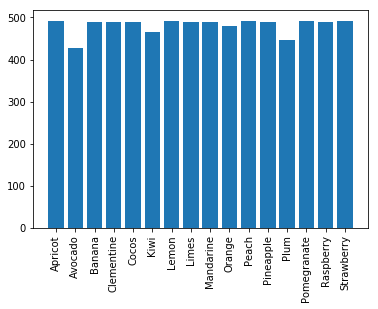

In [8]:
input_shape = train_image_array_gen.image_shape
classes = train_image_array_gen.class_indices ## conversion of the names to indeces
num_classes = len(classes)
class_counts = np.unique(train_image_array_gen.classes, return_counts=True)[1]
print("Shape:" + str(input_shape))
print("Number of classes:" + str(num_classes))
print("Classes:" + str(classes))

chart = plt.bar(classes.keys(), class_counts)
plt.xticks(rotation=90)
plt.show(chart)

In [9]:
train_samples = train_image_array_gen.n
valid_samples = valid_image_array_gen.n
print(train_samples, valid_samples)

7709 2428


In [10]:
# Create the model
### following are the steps that define the model
model = Sequential()
 
# Add the base model
model.add(base_model) ## define the model to train
 
# Add new layers
model.add(Flatten()) 
#model.add(Dense(519, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(output_n, activation='softmax')) ## output layer definition
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()
## non trainable parameters are the ones that has been excluded from training

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1605648   
Total params: 25,193,360
Trainable params: 1,605,648
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
### no calculation triggered in here, yet
### compile the model
model.compile(loss = 'categorical_crossentropy', ## this is the name of the loss function integrated in keras
              optimizer = RMSprop(lr = 0.0001, decay = 1e-6), ## 'RMSprop' is the optimizer function
              metrics = ['accuracy'])

In [12]:
history = model.fit_generator( ## fit_generator 
    train_image_array_gen,
    steps_per_epoch = int(train_samples / batch_size), ## look at each validation image ones
    epochs = 3, 
    validation_data = valid_image_array_gen,
    validation_steps = int(valid_samples / batch_size),
    verbose = 1
)

Epoch 1/3
100/240 [===========>..................] - ETA: 13:19 - loss: 0.2640 - acc: 0.9419

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-4edceea957a3>", line 7, in <module>
    verbose = 1
  File "/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 1415, in fit_generator
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training_generator.py", line 213, in fit_generator
    class_weight=class_weight)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 1215, in train_on_batch
    outputs = self.train_function(ins)
  File "/usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2666, in __call__
    return self._call(inputs)
  File "/usr/local/lib/python3.6/site-pack

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'lower right')
plt.show()